## Import some pkgs

In [1]:
import sys
sys.path.append("../../mypkg")

import scipy
import itertools

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import trange
from scipy.io import loadmat
from functools import partial
from easydict import EasyDict as edict

#plt.style.use('ggplot')
plt.rcParams["savefig.bbox"] = "tight"

In [2]:
# SBI and torch
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import analysis
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as sutils

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.distributions.multivariate_normal import MultivariateNormal

In [3]:
# my own fns
from brain import Brain
from FC_utils import build_fc_freq_m
from constants import RES_ROOT, DATA_ROOT, FIG_ROOT
from utils.misc import load_pkl, save_pkl
from utils.reparam import theta_raw_2out, logistic_np, logistic_torch

## Some fns

In [4]:
_minmax_vec = lambda x: (x-np.min(x))/(np.max(x)-np.min(x))

In [59]:
# transfer vec to a sym mat
def _vec_2mat(vec):
    mat = np.zeros((68, 68))
    mat[np.triu_indices(68, k = 1)] = vec
    mat = mat + mat.T
    return mat

In [60]:
## t test for each band
def paired_ttest(band, fc_types):
    typ_idx = fc_types.index(band)
    a = corrs_all["allbands"][:, typ_idx] 
    b = corrs_all[band]
    res = scipy.stats.ttest_rel(a, b)
    return res

def twosps_ttest(band, fc_types):
    typ_idx = fc_types.index(band)
    a = corrs_all["allbands"][:, typ_idx] 
    b = corrs_all[band]
    res = scipy.stats.ttest_ind(a, b)
    return res

In [61]:
# paras to model FC via sgm
def _paras_2FC(raw_params, brain, prior_bds, freqrange):
    params = []
    for raw_param, prior_bd in zip(raw_params, prior_bds):
        param =  _map_fn_torch(raw_param)*(prior_bd[1]-prior_bd[0]) + prior_bd[0]
        params.append(param)
    params = torch.tensor(params)
    
    params_dict = dict()
    params_dict["tau_e"] =  params[0].item()
    params_dict["tau_i"] =  params[1].item()
    params_dict["tauC"] =  params[2].item()
    params_dict["speed"] =  params[3].item()
    params_dict["alpha"] =  params[4].item()
    params_dict["gii"] =  params[5].item()
    params_dict["gei"] =  params[6].item()
    modelFC = build_fc_freq_m(brain , params_dict, freqrange)
    return modelFC[:68, :68]
    
#taue,taui,tauG,speed,alpha,gii,gei

In [62]:
def get_mode(x):
    kde_est = scipy.stats.gaussian_kde(x)
    xs = np.linspace(x.min(), x.max(), 500)
    ys = kde_est(xs)
    return xs[np.argmax(ys)]

### Some parameters

In [63]:
_paras = edict()
_paras.delta = [2, 3.5]
_paras.theta = [4, 7]
_paras.alpha = [8, 12]
_paras.beta = [13, 20]
_paras.beta_l = [13, 20]
_paras.beta_h = [15, 25]
_paras.cols = ["#1b9e77", "#d95f02", "#7570b3", "#e7298a", "#66a61e", "#e6ab02",]
_paras.markers = ["o", "h", "*", "+"]
_paras.xaxis_labs = [r"$\delta$", r"$\theta$", r"$\alpha$", r"$\beta$"]
_paras.barh = 0.05

In [64]:
# Parameter bounds for optimization
v_lower = 3.5-1.8
v_upper = 3.5+1.8
bnds = ((0.005,0.030), (0.005,0.2), (0.005,0.030), (v_lower,v_upper), (0.1,1.0), (0.5,10.0), (0.5,10.0))
#taue,taui,tauG,speed,alpha,gii,gei

In [65]:
paras = edict()

paras.fc_types = ["delta", "theta", "alpha", "beta_l"]
paras.freqranges =  [np.linspace(_paras[fc_type][0], _paras[fc_type][1], 5) 
                     for fc_type in paras.fc_types]
print(paras.freqranges)
paras.fs = 600
paras.num_nodes = 86 # Number of cortical (68) + subcortical nodes
paras.par_low =  np.array([ix[0] for ix in bnds])
paras.par_high = np.array([ix[1] for ix in bnds])
paras.prior_bds = np.array([paras.par_low, paras.par_high]).T
paras.prior_sd = 10
paras.add_v = 0.05

paras.dirs = edict()
paras.dirs.allbands = RES_ROOT/"newbdscorrectNewFC_posteriorMRmulDiffNum_delta-theta-alpha-beta_l_num10000_densitynsf_MR2_noise_sd80_addv5"
paras.dirs.delta = RES_ROOT/"newbdscorrectNewFC_posteriorMRmul_delta_num1000_densitynsf_MR3_noise_sd80_addv5"
paras.dirs.theta = RES_ROOT/"newbdscorrectNewFC_posteriorMRmul_theta_num1000_densitynsf_MR3_noise_sd80_addv5"
paras.dirs.alpha = RES_ROOT/"newbdscorrectNewFC_posteriorMRmul_alpha_num1000_densitynsf_MR3_noise_sd80_addv5"
paras.dirs.beta_l = RES_ROOT/"newbdscorrectNewFC_posteriorMRmul_beta_l_num1000_densitynsf_MR3_noise_sd80_addv5"

[array([2.   , 2.375, 2.75 , 3.125, 3.5  ]), array([4.  , 4.75, 5.5 , 6.25, 7.  ]), array([ 8.,  9., 10., 11., 12.]), array([13.  , 14.75, 16.5 , 18.25, 20.  ])]


In [66]:
# fn for reparemetering
_map_fn_torch = partial(logistic_torch, k=0.1)
_theta_raw_2out = partial(theta_raw_2out, map_fn=partial(logistic_np, k=0.1))

### Load the data

In [67]:
# SC
ind_conn_xr = xr.open_dataarray(DATA_ROOT/'individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values

# PSD
ind_psd_xr = xr.open_dataarray(DATA_ROOT/'individual_psd_reordered_matlab.nc')
ind_psd = ind_psd_xr.values
fvec = ind_psd_xr["frequencies"].values

In [68]:

def _add_v2con(cur_ind_conn):
    cur_ind_conn = cur_ind_conn.copy()
    add_v = np.max(cur_ind_conn)*paras.add_v # tuning 0.1
    np.fill_diagonal(cur_ind_conn[:34, 34:68], np.diag(cur_ind_conn[:34, 34:68]) + add_v)
    np.fill_diagonal(cur_ind_conn[34:68, :34], np.diag(cur_ind_conn[34:68, :34]) + add_v)
    np.fill_diagonal(cur_ind_conn[68:77, 77:], np.diag(cur_ind_conn[68:77, 77:]) + add_v)
    np.fill_diagonal(cur_ind_conn[77:, 68:77], np.diag(cur_ind_conn[77:, 68:77]) + add_v)
    return cur_ind_conn


if paras.add_v != 0:
    print(f"Add {paras.add_v} on diag")
    ind_conn_adds = [_add_v2con(ind_conn[:, :, ix]) for ix in range(36)]
    ind_conn = np.transpose(np.array(ind_conn_adds), (1, 2, 0))

Add 0.05 on diag


In [69]:
# Load true MEG FC time series:
true_FCs = []
for fc_type in paras.fc_types:
    dataPath = DATA_ROOT/f'./MEG_FC_{fc_type}_DK_networks_coh.mat'
    data = loadmat(dataPath);
    true_FC = data[f"MEG_{fc_type}_FC_networks_coh"]
    true_FCs.append(true_FC)

true_FC.shape

(68, 68, 36)

## All data analysis

### Corrs

In [70]:
typs = ["allbands", "delta", "theta", "alpha", "beta_l"]
corrs_all = edict()
for typ in typs:
    fil = list(paras.dirs[typ].glob("inf_res_fb.pkl"))[0]
    cur_res = load_pkl(fil, verbose=False)
    corrs_all[typ] = np.array(cur_res.corrs)

In [71]:
band = "alpha"
typ_idx = paras.fc_types.index(band)
a = corrs_all["allbands"][:, typ_idx] 
b = corrs_all[band]
res = scipy.stats.ttest_rel(a, b)
res

Ttest_relResult(statistic=-3.9947737436060056, pvalue=0.00031695723517284396)

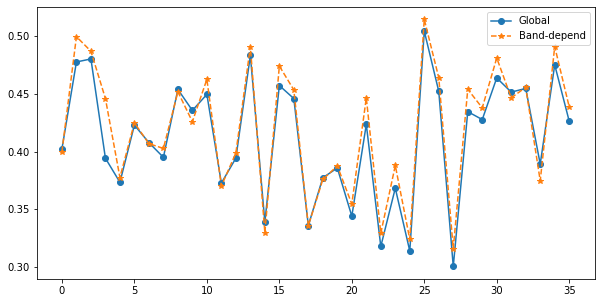

In [72]:
plt.figure(figsize=[10, 5])
plt.plot(a, "o-", label="Global")
plt.plot(b, "*--", label="Band-depend")
plt.legend()

Ttest_indResult(statistic=-0.4412166506135417, pvalue=0.6604159913690153)
Ttest_indResult(statistic=-2.3012699241275225, pvalue=0.024357907502400116)
Ttest_indResult(statistic=-0.6224031509872392, pvalue=0.535699069360916)
Ttest_indResult(statistic=1.8007057459277096, pvalue=0.07605697652851458)


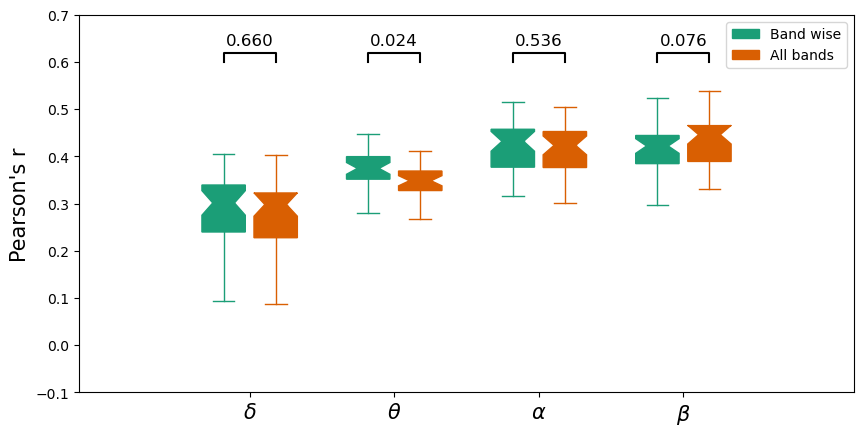

In [74]:
poss1 = np.array([0.4, 0.9, 1.4, 1.9])
poss2 = poss1 + 0.18
boxs = []
plt.figure(figsize=[10, 5], dpi=100)
bardlt = 0.02
barh = 0.6

for ix, typ in enumerate(paras.fc_types):
    xs = [poss1[ix], poss1[ix], poss2[ix], poss2[ix]]
    ys = [barh, barh+bardlt, barh+bardlt, barh]
    plt.plot(xs, ys, lw=1.5, c="k")
    box1 = plt.boxplot(corrs_all[typ], positions=[poss1[ix]],
                      notch=True, showfliers=False,  patch_artist=True);
    for item in ['boxes', 'whiskers',  'medians', 'caps']:
        plt.setp(box1[item], color=_paras.cols[0])
    
    box2 = plt.boxplot(corrs_all["allbands"][:, ix], positions=[poss2[ix]],
                      notch=True, showfliers=False,  patch_artist=True);
    for item in ['boxes', 'whiskers',  'medians', 'caps']:
        plt.setp(box2[item], color=_paras.cols[1])

    tt_res = twosps_ttest(typ, paras.fc_types)
    print(tt_res)
    plt.text((poss1[ix]+poss2[ix])/2, barh+bardlt+0.01, f"{tt_res.pvalue:.3f}", 
             ha='center', va='bottom', color="k", fontsize=12)
plt.xticks((poss1+poss2)/2, 
           _paras.xaxis_labs,
           #[typ.title() for typ in paras.fc_types][:-1]+["Beta"],
           fontsize=15)
plt.ylabel("Pearson's r", fontsize=15)
plt.legend([box1["boxes"][0], box2["boxes"][0]], ["Band wise", "All bands"])
plt.ylim([-0.1, 0.7])
plt.savefig(FIG_ROOT/"results_compare.jpg", dpi=1000)

### FC

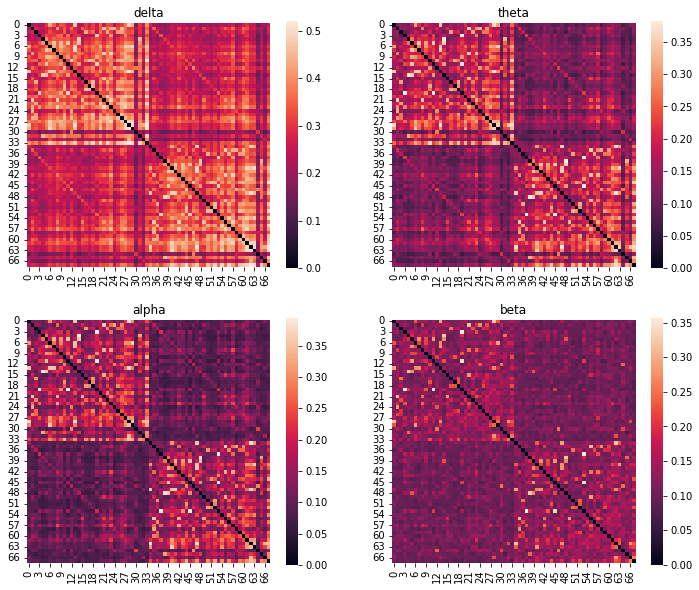

In [48]:
plt.figure(figsize=[12, 10])
for ix, typ in enumerate(paras.fc_types):
    fil = list(paras.dirs[typ].glob("inf_res_fb.pkl"))[0]
    cur_res = load_pkl(fil, 0)
    plt.subplot(2, 2, ix+1)
    plt.title(typ)
    sns.heatmap(np.array(cur_res.est_FCs).mean(axis=0), square=True)

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC1/SBI-SGM-FC/notebooks/../mypkg/../results/posteriorMRmulDiffNum_delta-theta-alpha-beta_num10000_densitynsf_MR2_noise_sd20_addv5/inf_res_fb.pkl


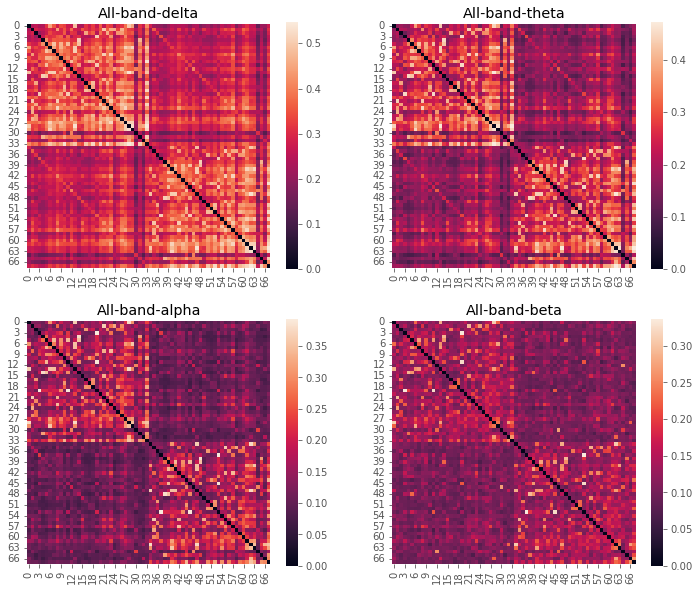

In [81]:
fil = list(paras.dirs["allbands"].glob("inf_res_fb.pkl"))[0]
cur_res = load_pkl(fil)
FCs = np.array(cur_res.est_FCs).mean(axis=0)
plt.figure(figsize=[12, 10])
for ix in range(4):
    plt.subplot(2, 2, ix+1)
    plt.title("All-band-"+paras.fc_types[ix])
    sns.heatmap(FCs[ix], square=True)